In [1]:
'''
Performs evaluation of aggregated VS measure and Dice prediction QC technique.
'''
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, confusion_matrix
#import utils as ut
import scikits.bootstrap as boot
import numpy as np
import random
import pickle
import os 
import tensorflow as tf
import scipy.stats

def rescale(data, max=255):
    '''
    rescale array to [0 max]
    '''
    
    data = data-np.min(np.ravel(data))
    data = max* (data/np.max(np.ravel(data)))
    return data

import numpy as np; np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# With N segmentations detected

## VS filtering

UNCERTAINTY MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.859
MEAN Dice AFTER filtering + CI: 0.8504 0.84 0.863
MEAN Precision + CI: 0.9297 0.8961 0.9757
MEAN Recall + CI: 0.8874 0.8397 0.9246
MEAN N observation AFTER filtering: 3.1999999999999993
MEAN Correlation + CI: 0.5219 0.4211 0.6129


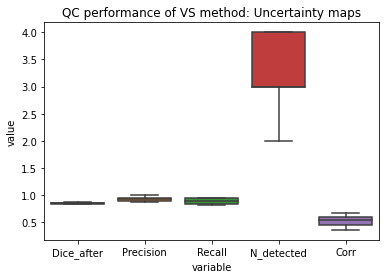

ERROR MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.859
MEAN Dice AFTER filtering + CI: 0.8286 0.8201 0.8371


<ipython-input-28-6146e31256da>:102: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  lci_pr, uci_pr = boot.ci(pres, np.mean)


MEAN Precision + CI: 0.95 0.875 0.975
MEAN Recall + CI: 0.8077 0.7678 0.8667
MEAN N observation AFTER filtering: 2.8000000000000007
MEAN Correlation + CI: -0.2517 -0.3571 -0.1154


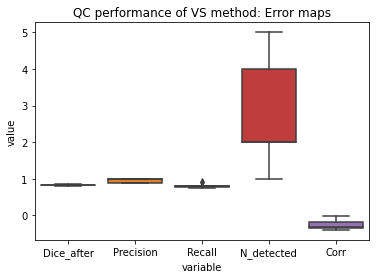

In [28]:
data_path = '/Users/elena.williams/reg_net/'


############################################### UNCERTAINTY ###############################################

print('UNCERTAINTY MAPS...')
final_res, m_Dice, n_obs, corr, rec, pres = [], [], [], [], [], []    
for i in np.arange(1,6):
    with open(data_path+str(i)+'entropy_unc_test.pkl', 'rb') as f:
        entropy_map_t = pickle.load(f)
    entropy_map_t = entropy_map_t[:,:,:,:,1]
    entropy_map_t = rescale(entropy_map_t, max=1)
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    unc_sum = []
    for k in np.arange(0,21):
        value = (np.sum(entropy_map_t[k,:,:,:]))
        unc_sum.append(value)
    unc_sum = np.array(unc_sum)
    coef = np.array(scipy.stats.pearsonr(dice_test, unc_sum))
    dice_filtered = dice_test[unc_sum > 1100]
    #print(true_dice_failed.shape)
    fake = unc_sum < 1100
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    corr.append(coef[0])
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)

    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
############################################### ERROR  ###############################################
df = pd.DataFrame(data = [final_res, pres, rec, 21-n_obs.squeeze(), corr])
df = df.T
df.columns = ['Dice_after','Precision','Recall','N_detected', 'Corr']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of VS method: Uncertainty maps')

plt.show()

print('ERROR MAPS...')
final_res, m_Dice, n_obs, corr, rec, pres = [], [], [], [], [], []    
for i in np.arange(1,6):
    with open(data_path+str(i)+'em.pkl', 'rb') as f:
        em = pickle.load(f)
    em = np.squeeze(em)
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    em_sum = []
    for k in np.arange(0,21):
        value = (np.sum(em[k,:,:,:]))
        em_sum.append(value)
    em_sum = np.array(em_sum)
    coef = np.array(scipy.stats.pearsonr(dice_test, em_sum))
    dice_filtered = dice_test[em_sum > -50000]
    fake = em_sum < -100000
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    corr.append(coef[0])
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
df = pd.DataFrame(data = [final_res, pres, rec, 21-n_obs.squeeze(), corr])
df = df.T
df.columns = ['Dice_after','Precision','Recall','N_detected', 'Corr']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of VS method: Error maps')

plt.show()

## Regression method

IMAGE - PREDICTION MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8269 0.859
MEAN Dice AFTER filtering + CI: 0.8482 0.8365 0.8612
MEAN Precision + CI: 0.9054 0.8 0.9765
MEAN Recall + CI: 0.8373 0.8038 0.8758
MEAN N observation AFTER filtering: 2.6000000000000014
MEAN Correlation + CI: 0.5724 0.4983 0.6287
MEAN MAE + CI: 0.0537 0.0523 0.0557


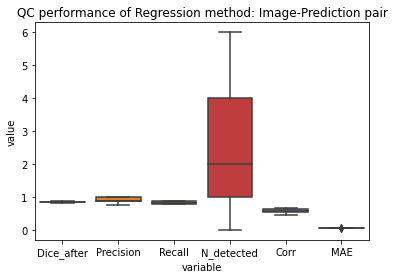

UNCERTAINTY - PREDICTION MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.859
MEAN Dice AFTER filtering + CI: 0.8525 0.8396 0.8654


<ipython-input-29-ee5a550b0239>:96: InstabilityWarning: Some values used extremal samples; results are probably unstable.
  lci_pr, uci_pr = boot.ci(pres, np.mean)


MEAN Precision + CI: 0.9684 0.8421 1.0
MEAN Recall + CI: 0.8667 0.7714 0.9524
MEAN N observation AFTER filtering: 1.8000000000000007
MEAN Correlation + CI: 0.7124 0.6543 0.7536
MEAN MAE + CI: 0.0486 0.0412 0.0623


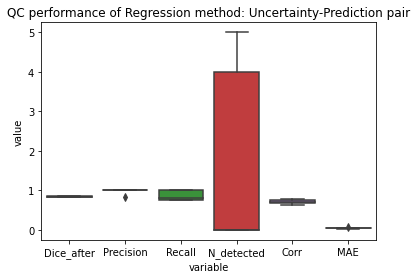

ERROR - PREDICTION MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8268 0.859
MEAN Dice AFTER filtering + CI: 0.8605 0.8401 0.8744
MEAN Precision + CI: 0.826 0.4142 0.9672
MEAN Recall + CI: 0.8679 0.7981 0.9556
MEAN N observation AFTER filtering: 4.800000000000001
MEAN Correlation + CI: 0.6765 0.4873 0.7441
MEAN MAE + CI: 0.0593 0.0441 0.0854


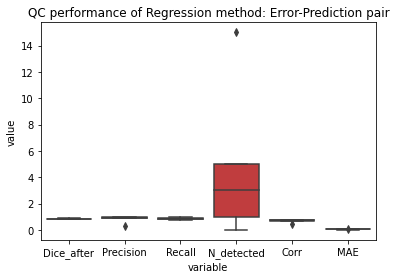

In [29]:
data_path = '/Users/elena.williams/reg_net/'

res_path = '/Users/elena.williams/res/'

############################################### IMAGE - PREDICTION ###############################################

print('IMAGE - PREDICTION MAPS...')
final_res, m_Dice, n_obs, pres, rec, corr, mae = [], [], [], [], [], [], []    
for i in np.arange(1,6):
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    pred = np.loadtxt(res_path+str(i)+'predictions_IP.txt', dtype=float)
    coef = np.loadtxt(res_path+str(i)+'corr_IP.txt', dtype=float)
    error = np.loadtxt(res_path+str(i)+'mae_IP.xt', dtype=float)
    dice_filtered = dice_test[pred > 0.75]
    fake = pred < 0.75
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    corr.append(coef[0])
    mae.append(error)


final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
mae = np.array(mae)
lci_mae, uci_mae = boot.ci(mae, np.mean)
print('MEAN MAE + CI:', np.round(np.mean(mae),4), np.round(lci_mae,4), np.round(uci_mae,4))

df = pd.DataFrame(data = [final_res, pres, rec, 21-n_obs.squeeze(), corr, mae])
df = df.T
df.columns = ['Dice_after','Precision','Recall','N_detected', 'Corr', 'MAE']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of Regression method: Image-Prediction pair')

plt.show()
############################################### UNCERTAINTY - PREDICTION ###############################################

print('UNCERTAINTY - PREDICTION MAPS...')
final_res, m_Dice, n_obs, pres, rec, corr, mae = [], [], [], [], [], [], []    
for i in np.arange(1,6):
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    pred = np.loadtxt(res_path+str(i)+'predictions_PE.txt', dtype=float)
    coef = np.loadtxt(res_path+str(i)+'corr_PE.txt', dtype=float)
    error = np.loadtxt(res_path+str(i)+'mae_PE.txt', dtype=float)
    dice_filtered = dice_test[pred > 0.75]
    fake = pred < 0.75
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    corr.append(coef[0])
    mae.append(error)

    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
mae = np.array(mae)
lci_mae, uci_mae = boot.ci(mae, np.mean)
print('MEAN MAE + CI:', np.round(np.mean(mae),4), np.round(lci_mae,4), np.round(uci_mae,4))
df = pd.DataFrame(data = [final_res, pres, rec, 21-n_obs.squeeze(), corr, mae])
df = df.T
df.columns = ['Dice_after','Precision','Recall','N_detected', 'Corr', 'MAE']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of Regression method: Uncertainty-Prediction pair')

plt.show()
############################################### ERROR - PREDICTION ###############################################


print('ERROR - PREDICTION MAPS...')
final_res, m_Dice, n_obs, pres, rec, corr, mae = [], [], [], [], [], [], []    
for i in np.arange(1,6):
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    pred = np.loadtxt(res_path+str(i)+'predictions_em.txt', dtype=float)
    coef = np.loadtxt(res_path+str(i)+'corr_em.txt', dtype=float)
    error = np.loadtxt(res_path+str(i)+'mae_em.txt', dtype=float)
    dice_filtered = dice_test[pred > 0.75]
    n = dice_filtered.shape
    true_dice_failed = dice_test[dice_test < 0.75]
    fake = pred < 0.75
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    corr.append(coef[0])
    mae.append(error)
    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
mae = np.array(mae)
lci_mae, uci_mae = boot.ci(mae, np.mean)
print('MEAN MAE + CI:', np.round(np.mean(mae),4), np.round(lci_mae,4), np.round(uci_mae,4))
df = pd.DataFrame(data = [final_res, pres, rec, 21-n_obs.squeeze(), corr, mae])
df = df.T
df.columns = ['Dice_after','Precision','Recall','N_detected', 'Corr', 'MAE']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of Regression method: Error-Prediction pair')

plt.show()

# Without N segmentations detected

## VS filtering

UNCERTAINTY MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.859
MEAN Dice AFTER filtering + CI: 0.8504 0.84 0.8622
MEAN Precision + CI: 0.9297 0.8961 0.9757
MEAN Recall + CI: 0.8874 0.8397 0.9319
MEAN N observation AFTER filtering: 3.1999999999999993
MEAN Correlation + CI: 0.5219 0.4211 0.6129


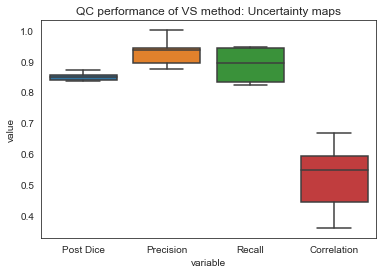

ERROR MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.859
MEAN Dice AFTER filtering + CI: 0.8366 0.8195 0.8582
MEAN Precision + CI: 0.4778 0.4287 0.5672
MEAN Recall + CI: 0.8291 0.7778 0.8803
MEAN N observation AFTER filtering: 9.8
MEAN Correlation + CI: -0.2517 -0.3571 -0.1154


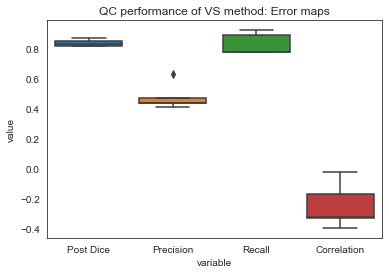

In [67]:
data_path = '/Users/elena.williams/reg_net/'


############################################### UNCERTAINTY ###############################################

print('UNCERTAINTY MAPS...')
final_res, m_Dice, n_obs, corr, rec, pres = [], [], [], [], [], []    
for i in np.arange(1,6):
    with open(data_path+str(i)+'entropy_unc_test.pkl', 'rb') as f:
        entropy_map_t = pickle.load(f)
    entropy_map_t = entropy_map_t[:,:,:,:,1]
    entropy_map_t = rescale(entropy_map_t, max=1)
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    unc_sum = []
    for k in np.arange(0,21):
        value = (np.sum(entropy_map_t[k,:,:,:]))
        unc_sum.append(value)
    unc_sum = np.array(unc_sum)
    coef = np.array(scipy.stats.pearsonr(dice_test, unc_sum))
    dice_filtered = dice_test[unc_sum > 1100]
    #print(true_dice_failed.shape)
    fake = unc_sum < 1100
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    corr.append(coef[0])
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)

    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))

df = pd.DataFrame(data = [final_res, pres, rec, corr])
df = df.T
df.columns = ['Post Dice','Precision', 'Recall','Correlation']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of VS method: Uncertainty maps')

plt.show()

df1 = df.copy()
############################################### ERROR  ###############################################


print('ERROR MAPS...')
final_res, m_Dice, n_obs, corr, rec, pres = [], [], [], [], [], []    
for i in np.arange(1,6):
    with open(data_path+str(i)+'em.pkl', 'rb') as f:
        em = pickle.load(f)
    em = np.squeeze(em)
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    em_sum = []
    for k in np.arange(0,21):
        value = (np.sum(em[k,:,:,:]))
        em_sum.append(value)
    em_sum = np.array(em_sum)
    coef = np.array(scipy.stats.pearsonr(dice_test, em_sum))
    dice_filtered = dice_test[em_sum < 20000]
    fake = em_sum < 20000
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    corr.append(coef[0])
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
df = pd.DataFrame(data = [final_res, pres, rec, corr])
df = df.T
df.columns = ['Post Dice','Precision','Recall', 'Correlation']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of VS method: Error maps')

plt.show()

df2 = df.copy()

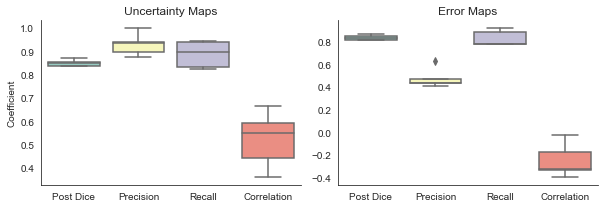

In [68]:
fig, ax = plt.subplots(1,2,figsize=(8.5,3))
sns.boxplot(x="variable", y="value", data=pd.melt(df1), ax=ax[0], palette="Set3")
sns.boxplot(x="variable", y="value", data=pd.melt(df2), ax=ax[1], palette="Set3")

ax[0].set(xlabel='', ylabel='Coefficient')
plt.title('QC performance of VS method')

ax[0].title.set_text('Uncertainty Maps')
ax[1].title.set_text('Error Maps')

ax[1].set(xlabel='', ylabel='')
sns.despine(left=False, bottom=False, top=True, right=True)

plt.tight_layout()

plt.savefig(os.path.join('plot_VS.pdf'))
plt.show()

In [ ]:
c = pd.concat([a,b],ignore_index=True)

## Regression method

IMAGE - PREDICTION MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8269 0.859
MEAN Dice AFTER filtering + CI: 0.8482 0.8373 0.8608
MEAN Precision + CI: 0.9054 0.8029 0.9765
MEAN Recall + CI: 0.8373 0.8038 0.8758
MEAN N observation AFTER filtering: 2.6000000000000014
MEAN Correlation + CI: 0.5724 0.495 0.6287
MEAN MAE + CI: 0.0537 0.052 0.0557


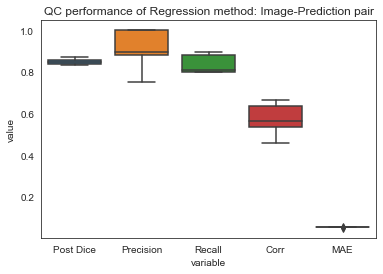

UNCERTAINTY - PREDICTION MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.8577
MEAN Dice AFTER filtering + CI: 0.8525 0.8375 0.8654


<ipython-input-70-3f027ee3bb7f>:97: InstabilityWarning: Some values used extremal samples; results are probably unstable.
  lci_pr, uci_pr = boot.ci(pres, np.mean)


MEAN Precision + CI: 0.9684 0.8421 1.0
MEAN Recall + CI: 0.8667 0.7714 0.9524
MEAN N observation AFTER filtering: 1.8000000000000007
MEAN Correlation + CI: 0.7124 0.6594 0.7538
MEAN MAE + CI: 0.0486 0.0412 0.0623


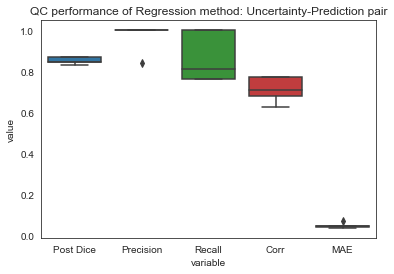

ERROR - PREDICTION MAPS...
MEAN Dice BEFORE filtering: + CI 0.84 0.8258 0.859
MEAN Dice AFTER filtering + CI: 0.8605 0.8417 0.8749
MEAN Precision + CI: 0.826 0.4142 0.9672
MEAN Recall + CI: 0.8679 0.7981 0.9556
MEAN N observation AFTER filtering: 4.800000000000001
MEAN Correlation + CI: 0.6765 0.4873 0.7446
MEAN MAE + CI: 0.0593 0.0441 0.0854


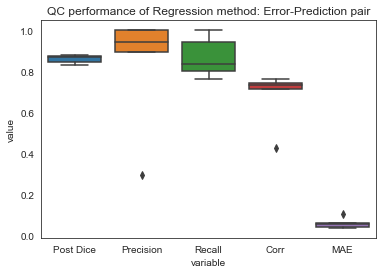

In [70]:
data_path = '/Users/elena.williams/reg_net/'

res_path = '/Users/elena.williams/res/'

############################################### IMAGE - PREDICTION ###############################################

print('IMAGE - PREDICTION MAPS...')
final_res, m_Dice, n_obs, pres, rec, corr, mae = [], [], [], [], [], [], []    
for i in np.arange(1,6):
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    pred = np.loadtxt(res_path+str(i)+'predictions_IP.txt', dtype=float)
    coef = np.loadtxt(res_path+str(i)+'corr_IP.txt', dtype=float)
    error = np.loadtxt(res_path+str(i)+'mae_IP.xt', dtype=float)
    dice_filtered = dice_test[pred > 0.75]
    fake = pred < 0.75
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    corr.append(coef[0])
    mae.append(error)


final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
mae = np.array(mae)
lci_mae, uci_mae = boot.ci(mae, np.mean)
print('MEAN MAE + CI:', np.round(np.mean(mae),4), np.round(lci_mae,4), np.round(uci_mae,4))

df = pd.DataFrame(data = [final_res, pres, rec, corr, mae])
df = df.T
df.columns = ['Post Dice','Precision','Recall', 'Corr', 'MAE']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of Regression method: Image-Prediction pair')

plt.show()
df1 = df.copy()
############################################### UNCERTAINTY - PREDICTION ###############################################

print('UNCERTAINTY - PREDICTION MAPS...')
final_res, m_Dice, n_obs, pres, rec, corr, mae = [], [], [], [], [], [], []    
for i in np.arange(1,6):
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    pred = np.loadtxt(res_path+str(i)+'predictions_PE.txt', dtype=float)
    coef = np.loadtxt(res_path+str(i)+'corr_PE.txt', dtype=float)
    error = np.loadtxt(res_path+str(i)+'mae_PE.txt', dtype=float)
    dice_filtered = dice_test[pred > 0.75]
    fake = pred < 0.75
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    corr.append(coef[0])
    mae.append(error)

    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
mae = np.array(mae)
lci_mae, uci_mae = boot.ci(mae, np.mean)
print('MEAN MAE + CI:', np.round(np.mean(mae),4), np.round(lci_mae,4), np.round(uci_mae,4))
df = pd.DataFrame(data = [final_res, pres, rec, corr, mae])
df = df.T
df.columns = ['Post Dice','Precision','Recall', 'Corr', 'MAE']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of Regression method: Uncertainty-Prediction pair')

plt.show()
df2 = df.copy()
############################################### ERROR - PREDICTION ###############################################


print('ERROR - PREDICTION MAPS...')
final_res, m_Dice, n_obs, pres, rec, corr, mae = [], [], [], [], [], [], []    
for i in np.arange(1,6):
    dice_test = np.loadtxt(data_path+str(i)+'dice_test.txt', dtype=float)
    dice_test = np.around(dice_test, decimals=4)
    pred = np.loadtxt(res_path+str(i)+'predictions_em.txt', dtype=float)
    coef = np.loadtxt(res_path+str(i)+'corr_em.txt', dtype=float)
    error = np.loadtxt(res_path+str(i)+'mae_em.txt', dtype=float)
    dice_filtered = dice_test[pred > 0.75]
    n = dice_filtered.shape
    true_dice_failed = dice_test[dice_test < 0.75]
    fake = pred < 0.75
    true = dice_test < 0.75
    TP, FP, FN, TN = confusion_matrix(true, fake).ravel()
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    n = dice_filtered.shape
    median_dice_f = np.median(dice_filtered)
    final_res.append(median_dice_f)
    m_Dice.append(np.median(dice_test))
    n_obs.append(n)
    pres.append(precision)
    rec.append(recall)
    corr.append(coef[0])
    mae.append(error)
    
final_res = np.array(final_res)
lci_fil, uci_fil = boot.ci(final_res, np.mean)
m_Dice = np.array(m_Dice)
lci_b, uci_b = boot.ci(m_Dice, np.mean)
print('MEAN Dice BEFORE filtering: + CI', np.round(np.mean(m_Dice),4), np.round(lci_b,4), np.round(uci_b,4))
print('MEAN Dice AFTER filtering + CI:', np.round(np.mean(final_res),4), np.round(lci_fil,4), np.round(uci_fil,4))
pres = np.array(pres)
lci_pr, uci_pr = boot.ci(pres, np.mean)
print('MEAN Precision + CI:', np.round(np.mean(pres),4), np.round(lci_pr,4), np.round(uci_pr,4))
rec = np.array(rec)
lci_rec, uci_rec = boot.ci(rec, np.mean)
print('MEAN Recall + CI:', np.round(np.mean(rec),4), np.round(lci_rec,4), np.round(uci_rec,4))
n_obs = np.array(n_obs)
#lci_n, uci_n = boot.ci(n_obs, np.mean)
print('MEAN N observation AFTER filtering:', 21-np.mean(n_obs))

corr = np.array(corr)
lci_corr, uci_corr = boot.ci(corr, np.mean)
print('MEAN Correlation + CI:', np.round(np.mean(corr),4), np.round(lci_corr,4), np.round(uci_corr,4))
mae = np.array(mae)
lci_mae, uci_mae = boot.ci(mae, np.mean)
print('MEAN MAE + CI:', np.round(np.mean(mae),4), np.round(lci_mae,4), np.round(uci_mae,4))

df = pd.DataFrame(data = [final_res, pres, rec, corr, mae])
df = df.T
df.columns = ['Post Dice','Precision','Recall', 'Corr', 'MAE']
sns.boxplot(x="variable", y="value", data=pd.melt(df))
plt.title('QC performance of Regression method: Error-Prediction pair')

plt.show()
df3 = df.copy()

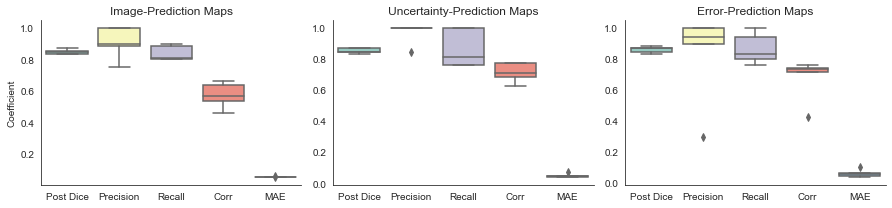

In [71]:
sns.set_style("white")
fig, ax = plt.subplots(1,3,figsize=(12.5,3))
sns.boxplot(x="variable", y="value", data=pd.melt(df1), ax=ax[0], palette="Set3")
sns.boxplot(x="variable", y="value", data=pd.melt(df2), ax=ax[1], palette="Set3")
sns.boxplot(x="variable", y="value", data=pd.melt(df3), ax=ax[2], palette="Set3")

ax[0].set(xlabel='', ylabel='Coefficient')

ax[0].title.set_text('Image-Prediction Maps')
ax[1].title.set_text('Uncertainty-Prediction Maps')
ax[2].title.set_text('Error-Prediction Maps')
sns.despine(left=False, bottom=False, top=True, right=True)

ax[1].set(xlabel='', ylabel='')
ax[2].set(xlabel='', ylabel='')

plt.tight_layout()

plt.savefig(os.path.join('plot_reg.pdf'))
plt.show()